In [1]:
from MulticlassDCP import BLEMulticlassDCP

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create, process dataframe

In [2]:
start_time = time.time()

In [3]:
b = BLEMulticlassDCP()

In [4]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


# Prep dataset

In [5]:
# BLE: Define which features to use
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length",
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

In [6]:
# Prep training set
df_train = df[df['Set']=='train']
print df_train['DeviceType'].value_counts()

door    116114
temp     46001
lock     34477
Name: DeviceType, dtype: int64


Initial test set distribution:
lock    210644
temp      7698
door      3587
Name: DeviceType, dtype: int64


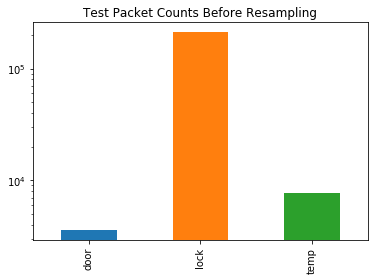

In [7]:
df_test = df[df['Set']=='test']

# Show initial test set imbalance
print "Initial test set distribution:"
print df_test['DeviceType'].value_counts()
df_test['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Before Resampling",logy=True);

In [8]:
# Downsample test set so that there is equal chance that the classifier will choose any given class
rds = RandomUnderSampler(random_state=42)
test_X_downsampled, test_y_downsampled = rds.fit_resample(df_test[features_list], df_test['DeviceType'])

# Show class counts after downsampling
unique, counts = np.unique(test_y_downsampled, return_counts=True)
print np.asarray((unique, counts)).T

[['door' 3587]
 ['lock' 3587]
 ['temp' 3587]]


In [9]:
# Recreate df_test 
df_test_downsampled = pd.DataFrame(test_X_downsampled,columns=features_list)
df_test_downsampled['DeviceType'] = test_y_downsampled

# Run multiclass on all features

In [10]:
multiclass_start = time.time()

preds, metrics, cms, feature_importance = b.run_multiclass(df_train, df_test_downsampled, features_list, y_list)

multiclass_end = time.time() - multiclass_start

## Report results

### Report confusion matrices

Confusion matrix, without normalization
[[  46    0 3541]
 [ 287 3300    0]
 [  42    0 3545]]
Confusion matrix, without normalization
[[   1 3586    0]
 [3587    0    0]
 [   1 3586    0]]
Confusion matrix, without normalization
[[  40    1 3546]
 [3587    0    0]
 [  26    0 3561]]


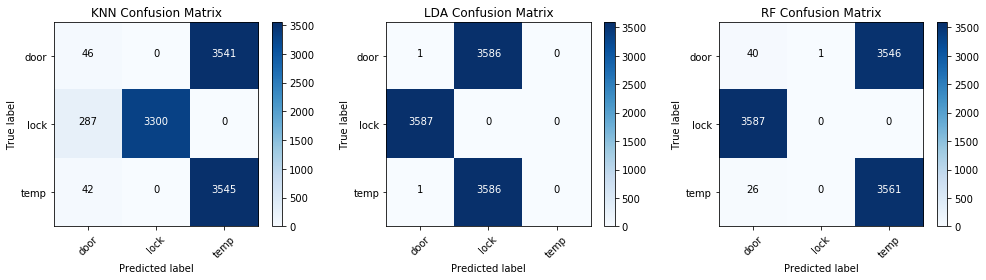

In [11]:
b.plot_all_confusion_matrices(cms, y_list)

### Report metrics

In [12]:
metrics_df = b.report_metrics(metrics, y_list, 'ble-multiclass_metrics')
display(metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Door,Precision_Lock,Precision_Temp,Recall_Door,Recall_Lock,Recall_Temp
KNN,0.547848,0.540983,0.640368,0.122667,1.0,0.500282,0.012824,0.919989,0.988291
RF,0.002379,0.170668,0.334634,0.010950,0.0,0.501055,0.011151,0.000000,0.992752
LDA,-0.612116,0.000093,0.000093,0.000279,0.0,0.000000,0.000279,0.000000,0.000000


### Report feature importance

In [13]:
f_i = b.report_featureimportance(feature_importance, features_list)
display(f_i)

PacketLength      0.32730
BLE_LL_Length     0.21198
Assoc_Packets     0.19311
SCAN_RSP          0.13465
ADV_IND           0.10600
SCAN_REQ          0.02598
Channel_39        0.00072
ADV_DIRECT_IND    0.00009
ADV_NONCONN_IND   0.00008
CONNECT_REQ       0.00003
Channel_0         0.00002
Channel_12        0.00002
dtype: float64

# Residuals Analysis

## Use *k* top features only

### Find *k* where *k* is the count of features that yields best BACC

In [14]:
fs_start = time.time()

# Find best features using KBest scheme
feature_selection = []
for i in range(0,len(f_i)):
    top_features = list(f_i.index[0:i+1])

    tf_preds, tf_metrics, tf_cms, tf_feature_importance = b.run_multiclass(df_train, df_test_downsampled, top_features, y_list,use_tuned=False)
    tf_metrics_df = b.report_metrics(tf_metrics, y_list, to_csv=False)
    
    ave = np.average(tf_metrics_df['Mean_Recall'])
    feature_selection.append(ave)
    
fs_end = time.time() - fs_start

/root/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [15]:
k = feature_selection.index(max(feature_selection))
print 'Best Mean Recall',max(feature_selection),":", k+1, "features"

Best Mean Recall 0.5464795712913918 : 3 features


In [16]:
feature_selection

[0.3333643093888424,
 0.3334262614998606,
 0.5464795712913918,
 0.32521760678995143,
 0.3249078462348604,
 0.3249078462348604,
 0.3248458941238423,
 0.3248458941238423,
 0.3250317504568968,
 0.3248458941238423,
 0.3250627265124059,
 0.3248149180683332]

### Run multiclass with top *k* features (*k* = 3)

In [17]:
# Run multiclass with top 3 features
tf_preds, tf_metrics, tf_cms, tf_feature_importance = b.run_multiclass(df_train, df_test_downsampled, list(f_i.index[0:k+1]), y_list,use_tuned=False)

In [18]:
tf_metrics_df = b.report_metrics(tf_metrics, y_list, 'ble-topfeatures_metrics')
display(tf_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Door,Precision_Lock,Precision_Temp,Recall_Door,Recall_Lock,Recall_Temp
KNN,0.57065,0.57796,0.65245,0.23345,1.00000,0.50043,0.01868,0.95567,0.98299
RF,0.57398,0.53314,0.65078,0.09859,1.00000,0.50084,0.00585,0.94898,0.99749
LDA,0.00118,0.17285,0.33398,0.01804,0.00000,0.50050,0.01868,0.00000,0.98327


### Plot confusion matrices

Confusion matrix, without normalization
[[  67    0 3520]
 [ 159 3428    0]
 [  61    0 3526]]
Confusion matrix, without normalization
[[  67    0 3520]
 [3587    0    0]
 [  59    1 3527]]
Confusion matrix, without normalization
[[  21    0 3566]
 [ 183 3404    0]
 [   9    0 3578]]


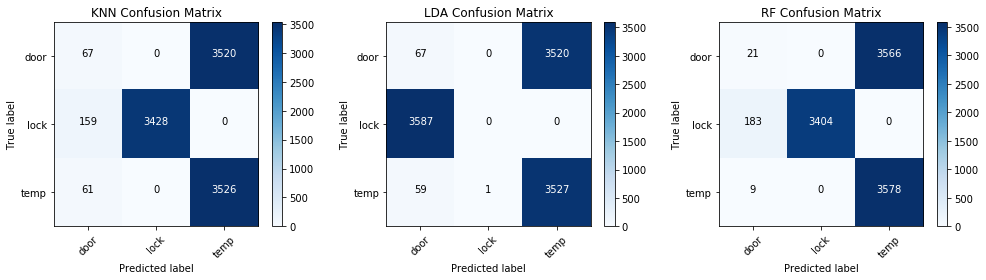

In [19]:
b.plot_all_confusion_matrices(tf_cms, y_list)

### Report feature importance of TF3

In [20]:
b.report_featureimportance(tf_feature_importance, f_i.index[0:k+1])

PacketLength    0.44528
Assoc_Packets   0.30459
BLE_LL_Length   0.25013
dtype: float64

## Error analysis

**Error 1**: The main error across all classifiers is the misclassification of door devices as temp devices.

In [21]:
# Get door and temp packets
df_train_doortemp = df_train[(df_train['DeviceType']=='door') | (df_train['DeviceType']=='temp')]

df_test_doortemp = df_test_downsampled[(df_test_downsampled['DeviceType']=='door') | (df_test_downsampled['DeviceType']=='temp')]

In [22]:
# Run multiclass on just the two device types
doortemp_preds, doortemp_metrics, doortemp_cms, doortemp_feature_importance = b.run_multiclass(df_train_doortemp, df_test_doortemp, features_list, ['door','temp'],use_tuned=False)

In [23]:
doortemp_metrics_df = b.report_metrics(doortemp_metrics, ['door','temp'], 'ble-doortemp_metrics')
display(doortemp_metrics_df)

,MCC,Mean_Precision,Mean_Recall,Precision_Door,Precision_Temp,Recall_Door,Recall_Temp
KNN,-0.01181,0.24997,0.49986,0.49993,0.00000,0.99972,0.00000
RF,0.02014,0.55196,0.50195,0.60294,0.50099,0.01143,0.99247
LDA,0.02510,0.59417,0.50167,0.68750,0.50084,0.00613,0.99721


Confusion matrix, without normalization
[[3586    1]
 [3587    0]]
Confusion matrix, without normalization
[[  22 3565]
 [  10 3577]]
Confusion matrix, without normalization
[[  41 3546]
 [  27 3560]]


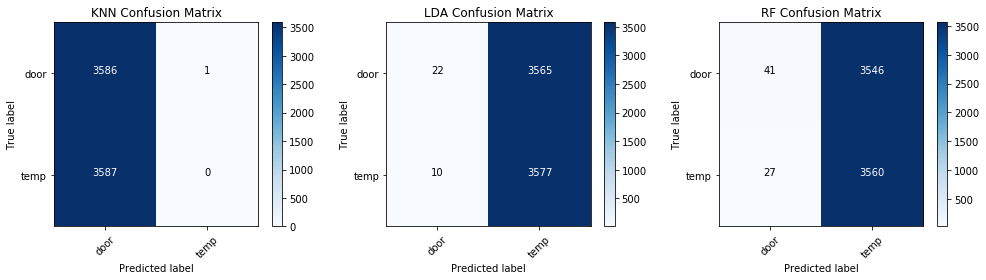

In [24]:
b.plot_all_confusion_matrices(doortemp_cms, ['door','temp'])

It appears that with just the two classes, the classifiers cannot distinguish between the two devices. The next step is to look at the feature selection

In [25]:
b.report_featureimportance(doortemp_feature_importance, features_list)

PacketLength      0.49302
BLE_LL_Length     0.37375
Assoc_Packets     0.07617
ADV_IND           0.03372
SCAN_REQ          0.01265
SCAN_RSP          0.00936
Channel_12        0.00097
Channel_39        0.00018
Channel_0         0.00010
CONNECT_REQ       0.00007
ADV_NONCONN_IND   0.00002
ADV_DIRECT_IND    0.00000
dtype: float64

In [26]:
# Run door vs temp with top 3 features
dt3_preds, dt3_metrics, dt3_cms, dt3_feature_importance = b.run_multiclass(df_train_doortemp, df_test_doortemp, features_list[0:3], ['door','temp'],use_tuned=False)

In [27]:
b.report_metrics(dt3_metrics, ['door','temp'], 'ble-dt3_metrics')

,MCC,Mean_Precision,Mean_Recall,Precision_Door,Precision_Temp,Recall_Door,Recall_Temp
KNN,-0.01181,0.24997,0.49986,0.49993,0.00000,0.99972,0.00000
RF,0.00849,0.51616,0.50112,0.53175,0.50057,0.01868,0.98355
LDA,0.00000,0.50000,0.50000,0.50000,0.50000,0.99972,0.00028


No difference with top 3 features.

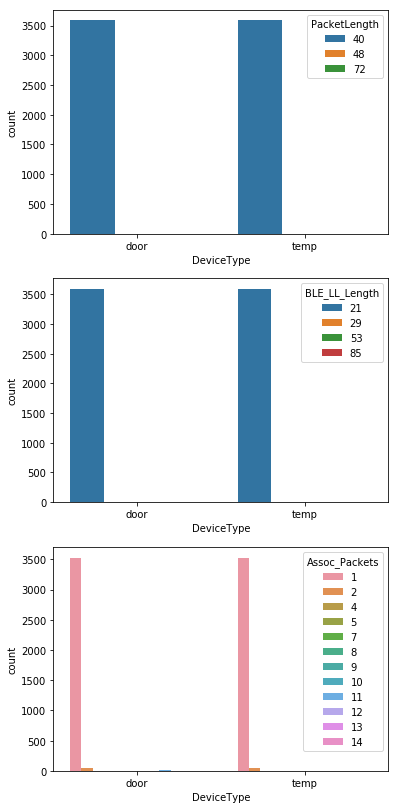

In [28]:
f, axes = plt.subplots(3, 1, figsize=(6, 14))
sns.countplot(x='DeviceType', hue='PacketLength',ax=axes[0], data=df_test_doortemp);
sns.countplot(x='DeviceType', hue='BLE_LL_Length',ax=axes[1], data=df_test_doortemp);
sns.countplot(x='DeviceType', hue='Assoc_Packets',ax=axes[2], data=df_test_doortemp);

# Report times

In [29]:
print multiclass_end
print fs_end
end_time = time.time() - start_time
print end_time

66.2020738125
356.022985935
1094.28398108
